# Cleaning up AP participation data

OK, so all we could get from education dept was a PDF of a spreadsheet, that was not normalized, and contained AP enrollment as % of total enrollment for only ONE of the two years. So no useful comparison can be made. Why? Why would someone do this?

After OCRing it into a spreadsheet and cleaning it a little in Google sheets, I've got a CSV I can work with here. That sheet, along with two downloads from edsight.ct.gov are all we need for this analysis.

### Step 1: Check 2018 numbers

Because they've provided 2018 numbers, I can recalculate them all and make sure I come up with the same numbers.

### Step 2: Compute 2015 numbers

If Step 1 pans out, I can just reapply the same method to 2015 numbers to get the % of students in each district who take AP classes.

In [2]:
import pandas as pd

In [4]:
apdf = pd.read_csv("data/AP enrollment CLEANUP - FINAL.csv").set_index("District")
apdf.head()

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment
District,,,,,,,,,,,,,,,
Ansonia Public Schools,2015,144,99,53,9,2018,92,57,39,12,-0.36,-0.42,-0.26,3,0.09
Avon Public School District,2015,430,210,407,21,2018,640,338,542,24,0.49,0.61,0.33,3,0.33
Berlin Public School District,2015,287,179,206,20,2018,385,214,309,19,0.34,0.20,0.50,-1,0.23
Bethel Public School District,2015,386,201,273,24,2018,379,213,273,23,-0.02,0.06,0.00,-1,0.23
Bloomfield Public School District,2015,124,69,47,8,2018,111,62,50,10,-0.10,-0.10,0.06,2,0.09


In [126]:
def get_enrollment(year="2017-18"):
    fname = "data/enrollmentSingleYear-" + year + ".csv"
    
    ret = pd.read_csv(fname,skiprows=5).set_index("District")[["Grade " + str(x) for x in range(9, 13)]]

    ret = ret
    for c in ret.columns:
        ret[c] = pd.to_numeric(ret[c],errors="coerce")
    
    ret = ret.transpose().sum().transpose().to_frame()
    
    ret.columns = ["enrollment " + year]
    return ret
enrollment = get_enrollment("2014-15").join(get_enrollment("2017-18"),how="outer")
enrollment.head()

,enrollment 2014-15,enrollment 2017-18
District,,
Achievement First Hartford Academy Inc. District,120.0,162.0
Amistad Academy District,176.0,240.0
Andover School District,0.0,0.0
Ansonia School District,631.0,607.0
Area Cooperative Educational Services,276.0,241.0


In [127]:
enrollment[enrollment.index.str.contains("Bethel")]

,enrollment 2014-15,enrollment 2017-18
District,,
Bethel School District,896.0,925.0


In [128]:
apdf.join(enrollment,how="left").head()

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,clean_name,enrollment 2014-15,enrollment 2017-18
District,,,,,,,,,,,,,,,,,,
Ansonia Public Schools,2015,144,99,53,9,2018,92,57,39,12,-0.36,-0.42,-0.26,3,0.09,Ansonia,NaN,NaN
Avon Public School District,2015,430,210,407,21,2018,640,338,542,24,0.49,0.61,0.33,3,0.33,Avon,NaN,NaN
Berlin Public School District,2015,287,179,206,20,2018,385,214,309,19,0.34,0.20,0.50,-1,0.23,Berlin,NaN,NaN
Bethel Public School District,2015,386,201,273,24,2018,379,213,273,23,-0.02,0.06,0.00,-1,0.23,Bethel,NaN,NaN
Bloomfield Public School District,2015,124,69,47,8,2018,111,62,50,10,-0.10,-0.10,0.06,2,0.09,Bloomfield,NaN,NaN


### DAMN!

It looks like a bunhc of school names didn't match up. Can I just use the first word in each?

In [129]:
pd.DataFrame(apdf.index.map(lambda x: {"name":x.split(" ")[0]}).tolist())["name"].value_counts().head()

Regional    17
East         7
New          6
North        3
Windsor      2
Name: name, dtype: int64

### BLAST!

As seen above there are too many districts that start with "Regional" "East" "New", etc...

Let me try by removing the words "Public" and " Town"

In [188]:
def clean_name(x):
    return x.replace(" Public","").replace(" Town","")\
.replace(" 0"," ")\
.replace(" City","").replace(" Schools","").replace(" School District","").strip()

In [189]:
pd.DataFrame(apdf.index.map(lambda x: {
    "name":clean_name(x)
}).tolist())["name"].value_counts().head()

Wolcott       1
Monroe        1
Coventry      1
Rocky Hill    1
Ansonia       1
Name: name, dtype: int64

### OK, trying it...

In [190]:
apdf["clean_name"] = apdf.index.map(clean_name)

In [191]:
apdf["clean_name"]

District
Ansonia Public Schools                        Ansonia
Avon Public School District                      Avon
Berlin Public School District                  Berlin
Bethel Public School District                  Bethel
Bloomfield Public School District          Bloomfield
Bolton School District                         Bolton
Branford Public Schools                      Branford
Bridgeport City School District            Bridgeport
Bristol Public Schools                        Bristol
Brookfield Public School District          Brookfield
Canton Public Schools                          Canton
Cheshire Public School District              Cheshire
Clinton Public School District                Clinton
Colchester Public School District          Colchester
Coventry Public School District              Coventry
Cromwell Public Schools                      Cromwell
Danbury Public Schools                        Danbury
Darien Public Schools                          Darien
Derby Public School

In [192]:
enrollment["clean_name"] = enrollment.index.map(clean_name)

In [193]:
enrollment.head()

,enrollment 2014-15,enrollment 2017-18,clean_name
District,,,
Achievement First Hartford Academy Inc. District,120.0,162.0,Achievement First Hartford Academy Inc. District
Amistad Academy District,176.0,240.0,Amistad Academy District
Andover School District,0.0,0.0,Andover
Ansonia School District,631.0,607.0,Ansonia
Area Cooperative Educational Services,276.0,241.0,Area Cooperative Educational Services


In [194]:
combined = apdf.set_index("clean_name").join(enrollment.set_index("clean_name"))
combined.head()

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18
clean_name,,,,,,,,,,,,,,,,,
Ansonia,2015,144,99,53,9,2018,92,57,39,12,-0.36,-0.42,-0.26,3,0.09,631.0,607.0
Avon,2015,430,210,407,21,2018,640,338,542,24,0.49,0.61,0.33,3,0.33,1056.0,1019.0
Berlin,2015,287,179,206,20,2018,385,214,309,19,0.34,0.20,0.50,-1,0.23,926.0,916.0
Bethel,2015,386,201,273,24,2018,379,213,273,23,-0.02,0.06,0.00,-1,0.23,896.0,925.0
Bloomfield,2015,124,69,47,8,2018,111,62,50,10,-0.10,-0.10,0.06,2,0.09,672.0,657.0


In [195]:
combined[combined["enrollment 2014-15"].isnull()]

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18
clean_name,,,,,,,,,,,,,,,,,


In [196]:
combined[combined["enrollment 2017-18"].isnull()]

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18
clean_name,,,,,,,,,,,,,,,,,


# Woo!

Nothing in those two dataframes mean there are no null values for enrollment. Weeee

### Now to calculate 2018 figures

In [197]:
combined.head()

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18
clean_name,,,,,,,,,,,,,,,,,
Ansonia,2015,144,99,53,9,2018,92,57,39,12,-0.36,-0.42,-0.26,3,0.09,631.0,607.0
Avon,2015,430,210,407,21,2018,640,338,542,24,0.49,0.61,0.33,3,0.33,1056.0,1019.0
Berlin,2015,287,179,206,20,2018,385,214,309,19,0.34,0.20,0.50,-1,0.23,926.0,916.0
Bethel,2015,386,201,273,24,2018,379,213,273,23,-0.02,0.06,0.00,-1,0.23,896.0,925.0
Bloomfield,2015,124,69,47,8,2018,111,62,50,10,-0.10,-0.10,0.06,2,0.09,672.0,657.0


In [198]:
combined["2018_check"] = combined["Testers.1"] / combined["enrollment 2017-18"]
combined.head()

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18,2018_check
clean_name,,,,,,,,,,,,,,,,,,
Ansonia,2015,144,99,53,9,2018,92,57,39,12,-0.36,-0.42,-0.26,3,0.09,631.0,607.0,0.093904
Avon,2015,430,210,407,21,2018,640,338,542,24,0.49,0.61,0.33,3,0.33,1056.0,1019.0,0.331698
Berlin,2015,287,179,206,20,2018,385,214,309,19,0.34,0.20,0.50,-1,0.23,926.0,916.0,0.233624
Bethel,2015,386,201,273,24,2018,379,213,273,23,-0.02,0.06,0.00,-1,0.23,896.0,925.0,0.230270
Bloomfield,2015,124,69,47,8,2018,111,62,50,10,-0.10,-0.10,0.06,2,0.09,672.0,657.0,0.094368


### Looks right... formal test

In [199]:
def samesies(a, b):
    """ Check if two decimals are the same when rounded to ints"""
    return round(a) == round(b)

print(samesies(0.9, 0.99))
print(samesies(0.5,0.4))

True
False


In [200]:
test_df = combined[["2018 testers % of enrollment","2018_check"]]
test_df["SAME"] = test_df.apply(lambda x: samesies(
    x["2018 testers % of enrollment"]*100,
    x["2018_check"]*100
),axis=1)
print(len(test_df[test_df["SAME"]]))
print(len(test_df[test_df["SAME"] == False]))


120
0


/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [201]:
test_df[test_df["SAME"] == False]

,2018 testers % of enrollment,2018_check,SAME
clean_name,,,


In [202]:
combined[combined.index.str.contains("Region")]

,AP Year,Exams,Testers,Scores 3+,Courses offered,AP Year.1,Exams.1,Testers.1,Scores 3+.1,Courses offered.1,Exams change,Testers Change,Scores 3+ change,Courses Change,2018 testers % of enrollment,enrollment 2014-15,enrollment 2017-18,2018_check
clean_name,,,,,,,,,,,,,,,,,,
Regional 4,2015,155,110,115,15,2018,237,130,149,23,0.53,0.18,0.30,8,0.22,640.0,597.0,0.217755
Regional 1,2015,15,12,11,7,2018,20,15,10,6,0.33,0.25,-0.09,-1,0.04,406.0,384.0,0.039062
Regional 10,2015,241,138,199,13,2018,307,176,242,18,0.27,0.28,0.22,5,0.23,783.0,771.0,0.228275
Regional 11,2015,49,32,22,7,2018,59,28,26,9,0.20,-0.13,0.18,2,0.20,167.0,138.0,0.202899
Regional 12,2015,41,27,27,9,2018,102,63,54,16,1.49,1.33,1.00,7,0.24,272.0,265.0,0.237736
Regional 13,2015,142,71,105,9,2018,161,88,142,9,0.13,0.24,0.35,0,0.16,582.0,556.0,0.158273
Regional 14,2015,420,191,262,16,2018,478,232,281,17,0.14,0.21,0.07,1,0.32,763.0,720.0,0.322222
Regional 15,2015,437,235,377,18,2018,688,358,528,24,0.57,0.52,0.40,6,0.29,1217.0,1224.0,0.292484
Regional 16,2015,235,146,153,17,2018,243,153,171,16,0.03,0.05,0.12,-1,0.22,699.0,684.0,0.223684


In [204]:
combined["2018_pct"] = combined["2018_check"]
combined["2015_pct"] = combined["Testers"] / combined["enrollment 2014-15"]

In [214]:
combined["pct_change"] = (combined["2018_pct"] - combined["2015_pct"]) / combined["2015_pct"]
combined["point_change"] = (combined["2018_pct"] - combined["2015_pct"])
combined[["2015_pct","2018_pct","change"]]

,2015_pct,2018_pct,change
clean_name,,,
Ansonia,0.156894,0.093904,-0.401478
Avon,0.198864,0.331698,0.667966
Berlin,0.193305,0.233624,0.208582
Bethel,0.224330,0.230270,0.026478
Bloomfield,0.102679,0.094368,-0.080934
Bolton,0.126543,0.249110,0.968579
Branford,0.155242,0.135857,-0.124866
Bridgeport,0.045777,0.115242,1.517490
Bristol,0.201581,0.211854,0.050961


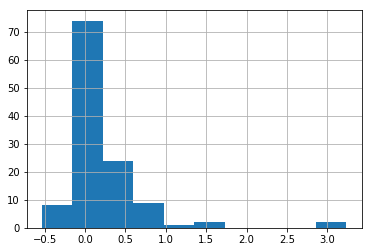

In [215]:
%matplotlib inline
combined["change"].hist()

In [217]:
combined.to_csv("COMBINED.csv")

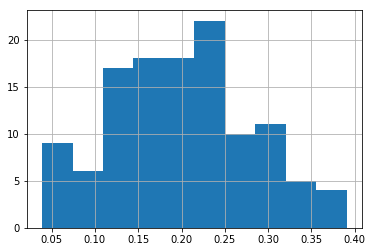

In [218]:
combined["2018_pct"].hist()

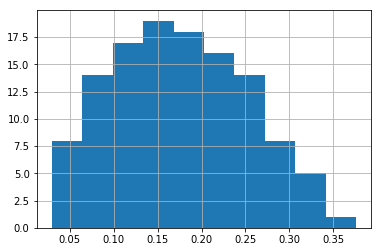

In [219]:
combined["2015_pct"].hist()